In [1]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
bitcoin_data = pd.read_csv('BTC-USDT-1h.csv')
bitcoin_data.drop(columns = ['close_time','quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore'],inplace=True)
bitcoin_data['open_time'] = pd.to_datetime(bitcoin_data['open_time'],unit='ms').astype('str')

In [3]:
bitcoin_data.head()

,open_time,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807


In [4]:
bitcoin_data['percentage_change'] = ((bitcoin_data['close']-bitcoin_data['open'])/bitcoin_data['open'])*100

In [5]:
bitcoin_data.shape

(43879, 7)

In [6]:
data_training = bitcoin_data[bitcoin_data['open_time']< '2022-01-01'].copy()
data_test = bitcoin_data[bitcoin_data['open_time']> '2022-01-01'].copy()
training_data = data_training.drop(['open_time'], axis = 1)

In [7]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)

In [8]:
X_train = [] 
Y_train = []
training_data.shape[0]
for i in range(60, training_data.shape[0]):
 X_train.append(training_data[i-60:i])
 Y_train.append(training_data[i,:])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(38162, 60, 6)

In [9]:
with tf.device('gpu'):
    model = Sequential() 
    model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.4)) 
    model.add(LSTM(units = 120, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(units =6))
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [21]:
history= model.fit(X_train, Y_train, epochs = 30, batch_size =250, validation_split=0.1)

Epoch 1/30
138/138 [==============================] - 76s 550ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 2/30
138/138 [==============================] - 75s 542ms/step - loss: 0.0019 - val_loss: 0.0091
Epoch 3/30
138/138 [==============================] - 74s 539ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 4/30
138/138 [==============================] - 77s 558ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 5/30
138/138 [==============================] - 81s 587ms/step - loss: 0.0015 - val_loss: 0.0080
Epoch 6/30
138/138 [==============================] - 75s 545ms/step - loss: 0.0015 - val_loss: 0.0112
Epoch 7/30
138/138 [==============================] - 75s 545ms/step - loss: 0.0014 - val_loss: 0.0114
Epoch 8/30
138/138 [==============================] - 75s 542ms/step - loss: 0.0013 - val_loss: 0.0109
Epoch 9/30
138/138 [==============================] - 74s 538ms/step - loss: 0.0013 - val_loss: 0.0091
Epoch 10/30
138/138 [==============================] - 74s 539ms/step - l

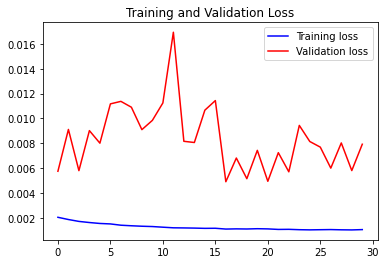

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [23]:
part_60_days = data_training.tail(60)
df= part_60_days.append(data_test, ignore_index = True)
df = df.drop(['open_time'], axis = 1)
df.head()

C:\Users\gampa\AppData\Local\Temp\ipykernel_18016\2070271018.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df= part_60_days.append(data_test, ignore_index = True)


,open,high,low,close,volume,percentage_change
0,47737.96,47777.77,46661.00,46824.23,4248.68643,-1.914053
1,46824.23,47458.92,46586.62,47402.65,2455.36215,1.235301
2,47402.65,47888.92,47239.60,47826.00,3243.86459,0.893094
3,47826.00,48030.05,47721.71,47959.36,2180.51068,0.278844
4,47959.36,48038.92,47603.00,47727.43,1474.70054,-0.483597


In [24]:
inputs = scaler.transform(df)

In [25]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i]) 
    Y_test.append(inputs[i, : ])
X_test, Y_test = np.array(X_test), np.array(Y_test) 
Y_pred = model.predict(X_test)

177/177 [==============================] - 11s 60ms/step


In [26]:
scaler.scale_

array([1.52058369e-05, 1.51400454e-05, 1.52359616e-05, 1.52172977e-05,
       2.11614403e-05, 2.80998553e-02])

In [27]:
Y_test = scaler.inverse_transform(Y_test)
Y_pred = scaler.inverse_transform(Y_pred)

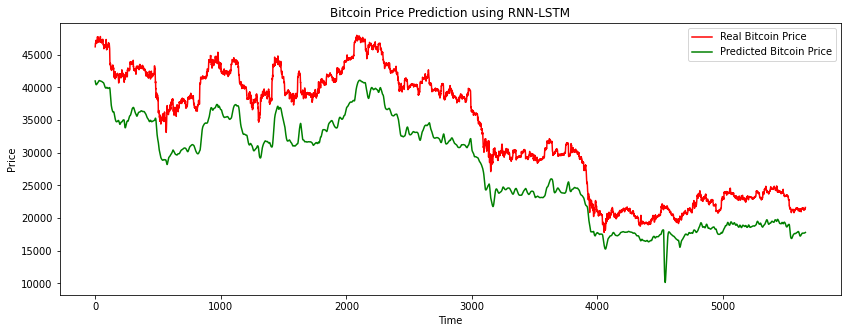

In [28]:
plt.figure(figsize=(14,5))
plt.plot(Y_test[:,0], color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred[:,0], color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()